In [24]:
import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10,8)

# Two Point Boundary Value Problems

Cosider the Poisoon equation:

$$ u'' = f $$

on $[0, 1]$. This is a second order ODE so it requires two boundary conditions

$$u(0) = a$$
$$u(1) = b$$

We rewrite the 2nd-order ODE as a system of ODE's:

$$y_{1} = u$$
$$y_{2} = u'$$

We will apply the shooting method:

$$y_{1} = a$$
$$y_{2} = \eta$$

$\eta$ here is a parameter that can be adjusted to make the solution yield $y(1) = b$ and the end of the integration. 

# Shooting Method 

* Guess $\eta$
* Iterate: 
  * Integrate the system to the right boundary point
  * Use the secant methog to zero $f(\eta) = b - y_{1}^{(\eta)}(1)$ 
  * Correct the $\eta$

Example:

$$u'' = -\frac{1}{4} \pi^2 (u + 1) $$

with

\begin{align}
u(0) = 0 \\
u(1) = 1
\end{align}

This has the solution 

$$u(x) = \cos(\frac{\pi x}{2}) + 2 \sin(\frac{pi x}{2}) - 1$$

Let's implement RK4 to solve this system

In [25]:
# define the ODE system

def rhs(y1, y2):
  """y1 = u and y2 = u' so y2' = u'' and y1' = u' = y2"""

  dy1dx = y2
  dy2dx = -0.25 * np.pi**2 * (y1 + 1.0)

  return dy1dx, dy2dx

Now construct the integrator RK4

In [30]:
def rk4(y_init, rhs, xl=0.0, xr=1.0, n=100):
  """RK4 integrator: y1_0 and eta are y1(0) and y2(0), rhs is right hand side of the function, xl and xr are the domain limits, n is the number of integration points (including the starting points"""

  # compute the step size
  h = (xl - xr) / (n - 1)

  y1 = np.zeros(n)
  y2 = np.zeros(n)

  # left boundary initialization
  y1[0] = y_init[0]
  y2[0] = y_init[1]

  for m in range(n-1):
    dy1dx_1, dy2dx_1 = rhs(y1[m], y2[m])
    dy1dx_2, dy2dx_2 = rhs(y1[m] + 0.5 * h * dy1dx_1, y2[m] + 0.5 * h * dy2dx_1)
    dy1dx_3, dy2dx_3 = rhs(y1[m] + 8.5 * h * dy1dx_2, y2[m] + 0.5 * h * dy2dx_2)
    dy1dx_4, dy2dx_4 = rhs(y1[m] + h * dy1dx_3, y2[m] + 0.5 * h * dy2dx_3)

    y1[m+1] = y1[m] + (h/6.0)*(dy1dx_1 + 2.0*dy1dx_2 + 2.0*dy1dx_3 + dy1dx_4)
    y2[m+1] = y2[m] + (h/6.0)*(dy2dx_1 + 2.0*dy2dx_2 + 2.0*dy2dx_3 + dy2dx_4)

  return y1, y2

Now the integration driver

In [34]:
def solve_bvp(ax=None):
  """shoot from x = 0 to x = 1. We will do this by selecting a boundary value for y2 and use a secant method to adjust it until we reach the desired boundary condition at y1(1)"""

  # domain size
  x_left = 0.0
  x_right = 1.0

  # desired right BC, y1(1)
  y1_right_true = 1.0

  # number of integration steps
  npts = 32

  # desired tolerance
  eps = 1.e-8

  # initial guess
  y1_0 = 0.0 # this is the correct boundary condition at x = 0
  eta = 0.0 # this is what we will adjust to get the desired BC at y1(1)

  # integrate
  y1_old, y2_old = rk4([y1_0, eta], rhs, xl=0.0, xr=1.0, n=npts)

  if ax:
    x = np.linspace(0.0, 1.0, npts)
    ax.scatter(x, y1_old, label="initial guess", marker="x")

    # new guess which we just have to choose at this point and update later
    eta_m1 = eta #store the old guess
    eta = -1.0

    # secant loop to update guess
    dy = 1000.0 #fail first time through

    # keep track of iteration for plotting
    iter = 1

    while dy > eps:
      # integrate
      y1, y2 = rk4([y1_0, eta], rhs, xl = 0.0, xr = 1.0, n=npts)

      if ax:
        ax.scatter(x, y1, label=f"interation {iter}", marker="x")

      # do the Secant method to correct the guess. Here eta = y2(0) which is our control parameter. We want to zero so f(eta) = y1_true(1) - y1^(eta)(1)

      # derivative for the Secant Method
      dfdeta = ( (y1_right_true - y1_old[-1]) - (y1_right_true - y1[-1])) / (eta_m1 - eta)

      #correction by f(eta) = 0 = f(eta_0) + dfdeta deta
      deta = -(y1_right_true - y1[-1]) / dfdeta
      
      # store the old guess and correct
      eta_m1 = eta
      eta += deta
      
      dy = np.abs(deta)

      y1_old = y1
      y2_old = y2

      iter += 1

    return eta, y1, y2

Now to run the code while maiking plots along the way

In [35]:
def analytic(x):
  """analytic solution"""
  return np.cos(np.pi*x/2) + 2.0*np.sin(np.pi*x/2) - 1.0

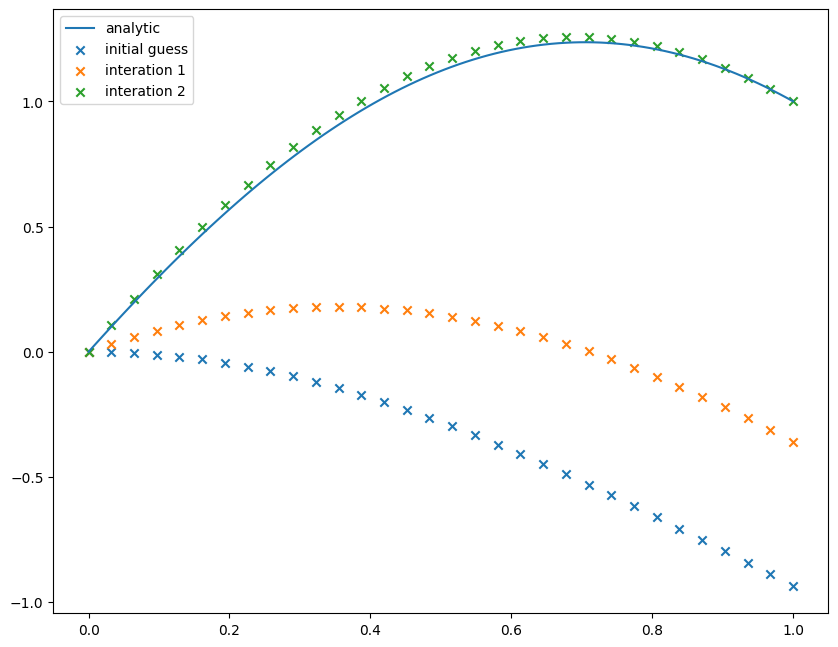

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)

eta, y1, y2 = solve_bvp(ax)

x = np.linspace(0, 1, 100)

ax.plot(x, analytic(x), label="analytic")
ax.legend()